### Initialize 

In [ ]:
!pip install requests beautifulsoup4 pandas numpy tqdm matplotlib seaborn python-dotenv torch scikit-learn webdriver_manager selenium

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Machine learning libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load environment variables for GitHub API
load_dotenv()
GITHUB_TOKEN = open("github_api.key","r").read()
if not GITHUB_TOKEN:
    logger.error("GitHub token not found. Please set GITHUB_TOKEN in .env file")
    raise ValueError("GitHub token not found")

headers = {
    'Authorization': f'token {GITHUB_TOKEN}',
    'Accept': 'application/vnd.github.v3+json'
}

### List of Projects - from Apache website

In [10]:
project_list_data = open("Apache_projects.html","r").read()
# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(project_list_data, 'html.parser')

# Find all <a> tags
a_tags = soup.find_all('a')

# Extract the href and text from each <a> tag
links_and_names = [(a.text, a['href']) for a in a_tags if 'href' in a.attrs]

# Convert the list to a pandas DataFrame
df = pd.DataFrame(links_and_names, columns=['Name', 'Sublink'])

In [ ]:
def get_final_url(driver, url):
    driver.get(url)
    time.sleep(5)  # Wait for the redirect to complete
    return driver.current_url


# Configure Chrome options
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Set up WebDriver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

for i, row in df[:].iterrows():
    url = "https://projects.apache.org/" + row["Sublink"]
    # Load the page and allow time for JS to execute
    driver.get(url)
    time.sleep(10)  # Increase if needed

    # Get the fully rendered page source
    page = driver.page_source

    # Parse with BeautifulSoup
    soup = BeautifulSoup(page, 'html.parser')
    
    # Find all <li> tags containing <b>Git repository:</b>
    li_tags = soup.find_all('li')
    git_repo_link = None
    for li in li_tags:
        b_tag = li.find('b')
        if b_tag and b_tag.text == 'Git repository:':
            a_tag = li.find('a', href=True)
            if a_tag:
                git_repo_link = a_tag['href']
                break
    
    project_status = None
    for li in li_tags:
        b_tag = li.find('b')
        if b_tag and b_tag.get_text(strip=True) == 'Project status:':
            # Prefer extracting text from the <span> tag
            span_tag = li.find('span')
            if span_tag:
                project_status = span_tag.get_text(strip=True)
            else:
                # Fallback extraction if span is missing
                project_status = li.get_text(strip=True).split(":", 1)[-1].strip()
            break

    # If the git_repo_link points to an .apache.org page, get its final URL
    if git_repo_link and '.apache.org' in git_repo_link:
        git_repo_link = get_final_url(driver, git_repo_link)
    
    print("Git Repository Link:", git_repo_link)
    print("Project Status:", project_status)
    
    # Update DataFrame columns (ensure these columns exist in df)
    df.at[i, "Github_link"] = git_repo_link
    df.at[i, "Project_status"] = project_status

driver.quit()

# Print and save the DataFrame to CSV
print(df)
df.to_csv("Apache_projects.csv", index=False)

2025-03-12 07:35:05,237 - INFO - ====== WebDriver manager ======
2025-03-12 07:35:06,138 - INFO - Get LATEST chromedriver version for google-chrome
2025-03-12 07:35:06,609 - INFO - Get LATEST chromedriver version for google-chrome
2025-03-12 07:35:10,395 - INFO - Driver [C:\Users\abhijeet\.wdm\drivers\chromedriver\win64\134.0.6998.88\chromedriver-win32/chromedriver.exe] found in cache


Git Repository Link: https://github.com/apache/db-jdo
Project Status: Active
Git Repository Link: https://github.com/apache/ant-antlibs-dotnet
Project Status: Active
Git Repository Link: https://github.com/apache/accumulo
Project Status: Active
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/age
Project Status: Active
Git Repository Link: https://github.com/apache/airavata
Project Status: Active
Git Repository Link: https://github.com/apache/airflow.git
Project Status: Active
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/ambari
Project Status: Active
Git Repository Link: None
Project Status: Incubating
Git Repository Link: None
Project Status: Active
Git Repository Link: http://git@github.com:apache/incubator-annotator.git
Project Status: Incubating
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/ant
Project Status: Active
Git Repository Link

In [13]:
df = pd.read_csv("Apache_projects.csv")
df

,Name,Sublink,Github_link,Project_status
0,Apache JDO,project.html?db-_jdo,https://github.com/apache/db-jdo,Active
1,Apache .NET Ant Library,project.html?ant-dotnet,https://github.com/apache/ant-antlibs-dotnet,Active
2,Apache Accumulo,project.html?accumulo,https://github.com/apache/accumulo,Active
3,Apache ActiveMQ,project.html?activemq,NaN,Active
4,Apache AGE,project.html?age,https://github.com/apache/age,Active
...,...,...,...,...
382,Apache XTable (Incubating),project.html?incubator-xtable,NaN,NaN
383,Apache Yetus,project.html?yetus,NaN,NaN
384,Apache YuniKorn,project.html?yunikorn,NaN,NaN
385,Apache Zeppelin,project.html?zeppelin,NaN,NaN


### List of Projects - from Apache incubator projects

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

def parse_project_table(soup, section_id, project_type):

    header = soup.find("h3", id=section_id)
    if header is None:
        print(f"Section with id '{section_id}' not found.")
        return pd.DataFrame()
    
    table = header.find_next("table")
    if table is None:
        print(f"No table found after section '{section_id}'.")
        return pd.DataFrame()
    
    rows = table.find_all("tr")
    data = []
    # Skip header row (first row)
    for row in rows[1:]:
        row_id = row.get("id", "").strip()
        cells = row.find_all("td")
        # Ensure that there are at least 7 cells
        if len(cells) < 7:
            continue
        
        first_cell = cells[0]
        a_tag = first_cell.find("a", href=True)
        href = a_tag["href"] if a_tag and a_tag["href"].startswith("/projects/") else ""
        
        apache_sponsor = cells[3].get_text(strip=True)
        mentors = cells[4].get_text(strip=True)
        start_date = cells[5].get_text(strip=True)
        end_date = cells[6].get_text(strip=True)
        
        data.append({
            "id": row_id,
            "href": href,
            "type": project_type,
            "Apache Sponsor": apache_sponsor,
            "Mentors": mentors,
            "Start Date": start_date,
            "End Date": end_date
        })
    
    return pd.DataFrame(data)

def extract_all_repo_links(project_url):
 
    try:
        response = requests.get(project_url)
        response.raise_for_status()
        page_soup = BeautifulSoup(response.text, "html.parser")
    except Exception as e:
        print(f"Error fetching {project_url}: {e}")
        return [], []
    
    github_links = []
    gitbox_links = []
    
    for a in page_soup.find_all("a", href=True):
        href = a["href"]
        if "github.com" in href:
            github_links.append(href)
        if "gitbox" in href:
            gitbox_links.append(href)
    
    return github_links, gitbox_links

def main():
    # Read the HTML content from the file
    with open("Apache_incubator_projects.html", "r", encoding="utf-8") as f:
        html_content = f.read()
        
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Parse the two project tables
    df_graduated = parse_project_table(soup, "graduated", "Graduated Projects")
    df_retired   = parse_project_table(soup, "retired", "Retired Podlings")
    
    # Combine DataFrames
    combined_df = pd.concat([df_graduated, df_retired], ignore_index=True)
    
    # We'll store the lists of repo links in two new columns
    combined_df["github_links"] = ''
    combined_df["gitbox_links"] = ''
    
    base_url = "https://incubator.apache.org"
    
    for idx, row in combined_df.iterrows():
        href = row["href"]
        if not href:
            combined_df.at[idx, "github_links"] = []
            combined_df.at[idx, "gitbox_links"] = []
            continue
        project_url = base_url + href
        print(f"Processing: {project_url}")
        github_list, gitbox_list = extract_all_repo_links(project_url)
        combined_df.at[idx, "github_links"] = github_list
        combined_df.at[idx, "gitbox_links"] = gitbox_list
        # Be polite to the server
        time.sleep(1)
    
    # Determine the maximum number of GitHub and Gitbox links across all projects
    max_github = max(len(links) for links in combined_df["github_links"])
    max_gitbox = max(len(links) for links in combined_df["gitbox_links"])
    
    # For each index, create separate columns for each GitHub link (github_link1, github_link2, ...)
    for i in range(max_github):
        col_name = f"github_link{i+1}"
        combined_df[col_name] = combined_df["github_links"].apply(lambda links: links[i] if len(links) > i else "")
    
    # Similarly, create separate columns for each Gitbox link (gitbox_link1, gitbox_link2, ...)
    for i in range(max_gitbox):
        col_name = f"gitbox_link{i+1}"
        combined_df[col_name] = combined_df["gitbox_links"].apply(lambda links: links[i] if len(links) > i else "")
    
    # Optionally, drop the temporary list columns
    combined_df.drop(columns=["github_links", "gitbox_links"], inplace=True)
    
    # For demonstration, print the updated DataFrame
    print("\nUpdated DataFrame with individual GitHub and Gitbox link columns:")
    print(combined_df.to_string(index=False))
    
    # Save the DataFrame to a CSV file
    combined_df.to_csv("Apache_incubator_projects.csv", index=False)
    
    return combined_df

main()


Processing: https://incubator.apache.org/projects/abdera.html
Processing: https://incubator.apache.org/projects/accumulo.html
Processing: https://incubator.apache.org/projects/ace.html
Processing: https://incubator.apache.org/projects/activemq.html
Processing: https://incubator.apache.org/projects/age.html
Processing: https://incubator.apache.org/projects/airavata.html
Processing: https://incubator.apache.org/projects/airflow.html
Processing: https://incubator.apache.org/projects/allura.html
Processing: https://incubator.apache.org/projects/ambari.html
Processing: https://incubator.apache.org/projects/amber.html
Processing: https://incubator.apache.org/projects/answer.html
Processing: https://incubator.apache.org/projects/any23.html
Processing: https://incubator.apache.org/projects/apex.html
Processing: https://incubator.apache.org/projects/apisix.html
Processing: https://incubator.apache.org/projects/apollo.html
Processing: https://incubator.apache.org/projects/aries.html
Processing: 

,id,href,type,Apache Sponsor,Mentors,Start Date,End Date,github_link1,github_link2,github_link3,...,gitbox_link1,gitbox_link2,gitbox_link3,gitbox_link4,gitbox_link5,gitbox_link6,gitbox_link7,gitbox_link8,gitbox_link9,gitbox_link10
0,abdera,/projects/abdera.html,Graduated Projects,Incubator,"Garrett Rooney, Paul Querna",2006-06-06,2008-11-08,,,,...,,,,,,,,,,
1,accumulo,/projects/accumulo.html,Graduated Projects,Incubator,"Benson Margulies, Alan Cabrera, Bernd Fondermann",2011-09-12,2012-03-21,,,,...,,,,,,,,,,
2,ace,/projects/ace.html,Graduated Projects,Board,"Niclas Hedhman, Carsten Ziegeler, Bertrand Del...",2009-04-24,2011-12-21,,,,...,,,,,,,,,,
3,activemq,/projects/activemq.html,Graduated Projects,Geronimo,James Strachan,2005-12-01,2007-02-06,,,,...,,,,,,,,,,
4,age,/projects/age.html,Graduated Projects,Incubator(Jim Jagielski),"Kevin Ratnasekera, Von Gosling, Felix Cheung, ...",2020-04-29,2022-05-18,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,xap,/projects/xap.html,Retired Podlings,Incubator,"Cliff Schmidt, Robert Burrell Donkin, Susan Wu",2006-05-22,2009-06-26,,,,...,,,,,,,,,,
325,xmlbeanscxx,/projects/xmlbeanscxx.html,Retired Podlings,Web Services,Cliff Schmidt,2005-06-06,2007-05-16,,,,...,,,,,,,,,,
326,yoko,/projects/yoko.html,Retired Podlings,Geronimo,"Ken Coar, Geir Magnusson Jr., James Strachan",2006-01-31,2007-12-17,,,,...,,,,,,,,,,
327,zetacomponents,/projects/zetacomponents.html,Retired Podlings,Incubator,"Julien Vermillard, Christian Grobmeier, Craig ...",2010-05-21,2012-04-20,http://github.com/zetacomponents,,,...,,,,,,,,,,


### List of Projects - from Apache github projects

In [ ]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# GitHub API URL and token
GITHUB_API_URL = "https://api.github.com"
GITHUB_TOKEN=""

# Headers for API Authentication
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

def fetch_repositories(org):
    repos = []
    page = 1
    while True:
        url = f"{GITHUB_API_URL}/orgs/{org}/repos?page={page}&per_page=100"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            print(f"Failed to fetch repositories: {response.status_code}")
            break
        data = response.json()
        if not data:
            break
        repos.extend(data)
        page += 1
        time.sleep(1)  # To avoid hitting rate limits
    return repos

def extract_repo_info(repos):

    repo_info = []
    for repo in repos:
        repo_info.append({
            'id': repo['id'],
            'node_id': repo['node_id'],
            'owner': repo['owner']['login'],
            'name': repo['name'],
            'url': repo['html_url'],
            'created_at': repo['created_at'],
            'updated_at': repo['updated_at'],
            'pushed_at': repo['pushed_at'],
            'size': repo['size'],
            'stargazers_count': repo['stargazers_count'],
            #'watchers_count': repo['watchers_count'],
            'language': repo['language'],
            'has_issues': repo['has_issues'],
            'has_projects': repo['has_projects'],
            'has_downloads': repo['has_downloads'],
            'has_wiki': repo['has_wiki'],
            'has_pages': repo['has_pages'],
            'has_discussions': repo['has_discussions'],
            'forks_count': repo['forks_count'],
            'mirror_url': repo['mirror_url'],
            'archived': repo['archived'],
            'disabled': repo['disabled'],
            'open_issues_count': repo['open_issues_count'],
            'license': repo['license'],
            'allow_forking': repo['allow_forking'],
            'is_template': repo['is_template'],
            'web_commit_signoff_required': repo['web_commit_signoff_required'],
            'forks': repo['forks'],
            'open_issues': repo['open_issues'],
            'watchers': repo['watchers'],
            'default_branch': repo['default_branch'],
            'permissions_admin': repo['permissions']['admin'],
            'permissions_maintain': repo['permissions']['maintain'],
            'permissions_push': repo['permissions']['push'],
            'permissions_pull': repo['permissions']['pull'],
        })
    return repo_info

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Fetch repositories for a given organization
organization = "apache"  # Replace with the desired organization
repositories = fetch_repositories(organization)

# Extract repository information
repo_info = extract_repo_info(repositories)

# Save the repository information to a CSV file
save_to_csv(repo_info, "Apache_github_repositories.csv")

Data saved to Apache_github_repositories.csv


### Combining all 3 lists

In [ ]:
import pandas as pd

# Load the data from the CSV files
incubator_data = pd.read_csv("Apache_incubator_projects.csv")
apache_project_data = pd.read_csv("Apache_projects.csv")
github_project_data = pd.read_csv("Apache_github_repositories.csv")

# Add a source column to identify the origin of each row
incubator_data['source'] = 'incubator'
apache_project_data['source'] = 'apache_project'
github_project_data['source'] = 'github'

# Combine the dataframes
combined_data = pd.concat([incubator_data, apache_project_data, github_project_data], axis=0, ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_data.to_csv("Apache_combined_data.csv", index=False)

# Display the combined dataframe
print(combined_data)

In [ ]:
values_apache_project_data = apache_project_data['Name'].values
values_github_project_data = github_project_data['name'].values
values_incubator_data = incubator_data['id'].values
values_apache_project_data = [x[7:].strip().lower() for x in values_apache_project_data]
print(values_apache_project_data)
count = 0
countt = 0
for element in github_project_data.iterrows():
    #print(element[1]['name'])
    if element[1]['name'] in values_incubator_data:
        incubator_data.remove()
        #print("exists in apache projects", count)
        count+=1
    if element[1]['name'] in values_apache_project_data:
        print("exists in github projects", countt)
        countt+=1

['jdo', '.net ant library', 'accumulo', 'activemq', 'age', 'airavata', 'airflow', 'allura', 'ambari', 'amoro (incubating)', 'anakia', 'annotator (incubating)', 'answer', 'ant', 'antunit', 'any23 (in the attic)', 'apex (in the attic)', 'apisix', 'archiva (in the attic)', 'aries', 'arrow', 'asterixdb', 'atlas', 'avro', 'axiom', 'axis2', 'baremaps (incubating)', 'batik', 'beam', 'beehive (in the attic)', 'bigtop', 'bookkeeper', 'brooklyn', 'brpc', 'buildr (in the attic)', 'buildstream', 'bval', 'calcite', 'camel', 'carbondata', 'cassandra', 'causeway', 'cayenne', 'celeborn', 'celix', 'chainsaw', 'chemistry (in the attic)', 'chukwa (in the attic)', 'clerezza (in the attic)', 'click (in the attic)', 'cloudberry (incubating)', 'cloudstack', 'cocoon (in the attic)', 'commons bcel', 'commons beanutils', 'commons bsf', 'commons chain (dormant)', 'commons cli', 'commons codec', 'commons collections', 'commons compress', 'commons configuration', 'commons crypto', 'commons csv', 'commons daemon', 

In [36]:
import pandas as pd

# Load your CSV files
incubator_data = pd.read_csv("Apache_incubator_projects.csv")
apache_project_data = pd.read_csv("Apache_projects.csv")
github_project_data = pd.read_csv("Apache_github_repositories.csv")

# Create standardized name columns for matching.
# For incubator_data, assume the name is in the column 'id'.
incubator_data['name_std'] = incubator_data['id'].astype(str).str.strip().str.lower()
# For apache_project_data, assume we need to drop the first 7 characters from the 'Name' column.
apache_project_data['name_std'] = apache_project_data['Name'].astype(str).str[7:].str.strip().str.lower()
# For github_project_data, assume the name is in the column 'name'
github_project_data['name_std'] = github_project_data['name'].astype(str).str.strip().str.lower()

# Assume the following for GitHub links:
# In apache_project_data, the column with the link is "Github_link"
# In github_project_data, the GitHub URL is in the column "github_url"

# Define the incubator columns to check for GitHub links.
incubator_link_cols = [
    "github_link1", "github_link2", "github_link2", "github_link4",
    "github_link5", "github_link6", "github_link7", "github_link8",
    "github_link9", "github_link10", "github_link11", "github_link12",
    "github_link13", "gitbox_link1", "gitbox_link2", "gitbox_link3",
    "gitbox_link4", "gitbox_link5", "gitbox_link6", "gitbox_link7",
    "gitbox_link8", "gitbox_link9", "gitbox_link10"
]

# Prepare column names with prefixes so that they are distinguishable in the final DataFrame.
def prefixed_cols(df, prefix):
    return [f"{prefix}_{col}" for col in df.columns if col != "name_std"]

github_cols = prefixed_cols(github_project_data, "github")
apache_cols = prefixed_cols(apache_project_data, "apache")
incubator_cols = prefixed_cols(incubator_data, "incubator")

# The combined DataFrame will have columns from all three sets.
combined_columns = github_cols + apache_cols + incubator_cols

# Instead of using DataFrame.append (removed in newer pandas), collect rows as dictionaries.
rows = []

# Loop over GitHub rows and try to match rows in Apache and Incubator dataframes.
for idx, github_row in github_project_data.iterrows():
    name = github_row['name_std']
    combined_row = {}
    
    # Add GitHub data (all columns except name_std) with prefix "github_".
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = github_row[col]
    
    # --- Apache matching ---
    # First try to match by standardized name.
    apache_match = apache_project_data[apache_project_data['name_std'] == name]
    # If no name match, check if Apache's Github_link equals github_url.
    if apache_match.empty:
        apache_match = apache_project_data[apache_project_data['Github_link'] == github_row['url']]
    
    if not apache_match.empty:
        match_idx = apache_match.index[0]
        apache_row = apache_project_data.loc[match_idx]
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = apache_row[col]
        # Remove the matched row from apache_project_data.
        apache_project_data = apache_project_data.drop(match_idx)
    else:
        # No match found; fill with NA for each Apache column.
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = pd.NA

    # --- Incubator matching ---
    # First try to match by standardized name.
    incubator_match = incubator_data[incubator_data['name_std'] == name]
    # If no name match, check if the github_url is in any of the incubator link columns.
    if incubator_match.empty:
        incubator_match = incubator_data[ incubator_data.apply(
            lambda row: any(github_row['url'] == str(row[col]).strip() 
                            for col in incubator_link_cols if pd.notna(row[col])), axis=1) ]
    
    if not incubator_match.empty:
        match_idx = incubator_match.index[0]
        incubator_row = incubator_data.loc[match_idx]
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = incubator_row[col]
        # Remove the matched row from incubator_data.
        incubator_data = incubator_data.drop(match_idx)
    else:
        # No match; fill with NA for each incubator column.
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = pd.NA

    # Append the combined row dictionary to our list.
    rows.append(combined_row)

# Append any remaining Apache rows that were not matched.
for idx, apache_row in apache_project_data.iterrows():
    combined_row = {}
    # Fill GitHub columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    # Add Apache data.
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = apache_row[col]
    # Fill Incubator columns with NA.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = pd.NA
    rows.append(combined_row)

# Append any remaining Incubator rows that were not matched.
for idx, incubator_row in incubator_data.iterrows():
    combined_row = {}
    # Fill GitHub and Apache columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = pd.NA
    # Add Incubator data.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = incubator_row[col]
    rows.append(combined_row)

# Create the final DataFrame from the accumulated rows with the specified column order.
result_df = pd.DataFrame(rows, columns=combined_columns)

# Save the resulting DataFrame to a CSV file (optional).
result_df.to_csv("Apache_combined_data.csv", index=False)

# Display the combined DataFrame.
print(result_df)


     github_id                github_node_id github_owner  \
0       160986  MDEwOlJlcG9zaXRvcnkxNjA5ODY=       apache   
1       160988  MDEwOlJlcG9zaXRvcnkxNjA5ODg=       apache   
2       160989  MDEwOlJlcG9zaXRvcnkxNjA5ODk=       apache   
3       160994  MDEwOlJlcG9zaXRvcnkxNjA5OTQ=       apache   
4       160995  MDEwOlJlcG9zaXRvcnkxNjA5OTU=       apache   
...        ...                           ...          ...   
3020      <NA>                          <NA>         <NA>   
3021      <NA>                          <NA>         <NA>   
3022      <NA>                          <NA>         <NA>   
3023      <NA>                          <NA>         <NA>   
3024      <NA>                          <NA>         <NA>   

               github_name                                      github_url  \
0                tapestry3             https://github.com/apache/tapestry3   
1                apr-iconv             https://github.com/apache/apr-iconv   
2                tapestry4       

In [45]:
import pandas as pd

# Load your CSV files
incubator_data = pd.read_csv("Apache_incubator_projects.csv")
apache_project_data = pd.read_csv("Apache_projects.csv")
github_project_data = pd.read_csv("Apache_github_repositories.csv")

# Create standardized name columns for matching.
# For incubator_data, assume the name is in the column 'id'.
incubator_data['name_std'] = incubator_data['id'].astype(str).str.strip().str.lower()
# For apache_project_data, assume we need to drop the first 7 characters from the 'Name' column.
apache_project_data['name_std'] = apache_project_data['Name'].astype(str).str[7:].str.strip().str.lower()
# For github_project_data, assume the name is in the column 'name'
github_project_data['name_std'] = github_project_data['name'].astype(str).str.strip().str.lower()

# Assume the following for GitHub links:
# In apache_project_data, the column with the link is "Github_link"
# In github_project_data, the GitHub URL is in the column "url" (adjust if necessary)

# Define the incubator columns to check for GitHub links.
incubator_link_cols = [
    "github_link1", "github_link2", "github_link3", "github_link4",
    "github_link5", "github_link6", "github_link7", "github_link8",
    "github_link9", "github_link10", "github_link11", "github_link12",
    "github_link13", "gitbox_link1", "gitbox_link2", "gitbox_link3",
    "gitbox_link4", "gitbox_link5", "gitbox_link6", "gitbox_link7",
    "gitbox_link8", "gitbox_link9", "gitbox_link10"
]

# Prepare column names with prefixes so that they are distinguishable in the final DataFrame.
def prefixed_cols(df, prefix):
    return [f"{prefix}_{col}" for col in df.columns if col != "name_std"]

github_cols = prefixed_cols(github_project_data, "github")
apache_cols = prefixed_cols(apache_project_data, "apache")
incubator_cols = prefixed_cols(incubator_data, "incubator")

# The combined DataFrame will have columns from all three sets.
combined_columns = github_cols + apache_cols + incubator_cols

# Instead of using DataFrame.append (removed in newer pandas), collect rows as dictionaries.
rows = []

# Loop over GitHub rows and try to match rows in Apache and Incubator dataframes.
for idx, github_row in github_project_data.iterrows():
    name = github_row['name_std']
    combined_row = {}
    
    # Add GitHub data (all columns except name_std) with prefix "github_".
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = github_row[col]
    
    # --- Apache matching ---
    # First try to match by standardized name.
    apache_match = apache_project_data[apache_project_data['name_std'] == name]
    # If no name match, check if Apache's Github_link equals github_row['url'].
    if apache_match.empty:
        apache_match = apache_project_data[apache_project_data['Github_link'] == github_row['url']]
    
    if not apache_match.empty:
        match_idx = apache_match.index[0]
        apache_row = apache_project_data.loc[match_idx]
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = apache_row[col]
        # Remove the matched row from apache_project_data.
        apache_project_data = apache_project_data.drop(match_idx)
    else:
        # No match found; fill with NA for each Apache column.
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = pd.NA

    # --- Incubator matching ---
    # First try to match by standardized name.
    incubator_match = incubator_data[incubator_data['name_std'] == name]
    # If no name match, check if the github URL is in any of the incubator link columns.
    if incubator_match.empty:
        incubator_match = incubator_data[incubator_data.apply(
            lambda row: any(github_row['url'] == str(row[col]).strip() for col in incubator_link_cols if pd.notna(row[col])),
            axis=1)]
    
    if not incubator_match.empty:
        match_idx = incubator_match.index[0]
        incubator_row = incubator_data.loc[match_idx]
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = incubator_row[col]
        # Remove the matched row from incubator_data.
        incubator_data = incubator_data.drop(match_idx)
    else:
        # No match; fill with NA for each incubator column.
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = pd.NA

    # Append the combined row dictionary to our list.
    rows.append(combined_row)

# Append any remaining Apache rows that were not matched.
for idx, apache_row in apache_project_data.iterrows():
    combined_row = {}
    # Fill GitHub columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    # Add Apache data.
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = apache_row[col]
    # Fill Incubator columns with NA.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = pd.NA
    rows.append(combined_row)

# Append any remaining Incubator rows that were not matched.
for idx, incubator_row in incubator_data.iterrows():
    combined_row = {}
    # Fill GitHub and Apache columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = pd.NA
    # Add Incubator data.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = incubator_row[col]
    rows.append(combined_row)

# Create the final DataFrame from the accumulated rows with the specified column order.
result_df = pd.DataFrame(rows, columns=combined_columns)

# --- Add final_status column ---
def get_final_status(row):
    # 1. Check incubator type, assumed to be in 'incubator_incubator_type'
    if pd.notna(row.get('incubator_type', None)):
        if row['incubator_type'] == "Graduated Projects":
            return 1
        elif row['incubator_type'] == "Retired Podlings":
            return 0
    # 2. Else, check apache_Project_status, assumed to be in 'apache_Project_status'
    if pd.notna(row.get('apache_Project_status', None)):
        status = row['apache_Project_status']
        if status == "Incubating":
            return -1
        elif status == "Active":
            return 1
        elif status == "Retired":
            return 0
    # 3. Else, check github_archived, assumed to be in 'github_github_archived'
    if pd.notna(row.get('github_archived', None)):
        archived = row['github_archived']
        # Assuming archived is boolean or a string representation.
        if archived in [True, 'True', 'true', 1]:
            return 0
        else:
            return 1
    return pd.NA

# Apply the function to each row to create the final_status column.
result_df['final_status'] = result_df.apply(get_final_status, axis=1)

# Move final_status to be the leftmost column.
cols = result_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('final_status')))
result_df = result_df[cols]

# Save the resulting DataFrame to a CSV file (optional).
result_df.to_csv("R_Apache_combined_data.csv", index=False)



     final_status github_id                github_node_id github_owner  \
0               0    160986  MDEwOlJlcG9zaXRvcnkxNjA5ODY=       apache   
1               1    160988  MDEwOlJlcG9zaXRvcnkxNjA5ODg=       apache   
2               0    160989  MDEwOlJlcG9zaXRvcnkxNjA5ODk=       apache   
3               1    160994  MDEwOlJlcG9zaXRvcnkxNjA5OTQ=       apache   
4               1    160995  MDEwOlJlcG9zaXRvcnkxNjA5OTU=       apache   
...           ...       ...                           ...          ...   
3020            0      <NA>                          <NA>         <NA>   
3021            0      <NA>                          <NA>         <NA>   
3022            0      <NA>                          <NA>         <NA>   
3023            0      <NA>                          <NA>         <NA>   
3024            0      <NA>                          <NA>         <NA>   

               github_name                                      github_url  \
0                tapestry3       

In [47]:
import pandas as pd

# Read the combined CSV file
df = pd.read_csv("R_Apache_combined_data.csv")

# Filter rows that have a non-null "github_name" and at least one of "apache_Name" or "incubator_id"
df_filtered = df[
    df['github_name'].notna() &
    (df['apache_Name'].notna() | df['incubator_id'].notna())
]

# Sort the filtered rows based on "github_size"
df_sorted = df_filtered.sort_values(by="github_size")

# Split the sorted data into two groups based on final_status (0 and 1)
group_0 = df_sorted[df_sorted['final_status'] == 0]
group_1 = df_sorted[df_sorted['final_status'] == 1]

# Determine the smaller group count to balance the dataset
min_count = min(len(group_0), len(group_1))

# Select the top min_count rows from each group (as the data is sorted by github_size)
balanced_0 = group_0.tail(min_count)
balanced_1 = group_1.tail(min_count)

# Concatenate the balanced groups
balanced_df = pd.concat([balanced_0, balanced_1]).sort_values(by="github_size")

# (Optional) Save the balanced dataframe to a CSV file
balanced_df.to_csv("R_Apache_balanced_data.csv", index=False)



In [ ]:
import requests
import pandas as pd
import time
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

# GitHub API URL and token
GITHUB_API_URL = "https://api.github.com"
GITHUB_TOKEN = ""  # Replace with your GitHub token

# Headers for API Authentication
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

def get_repo_creation_date(owner, repo):
    """
    Retrieve the repository creation date from the GitHub API.
    """
    repo_url = f"{GITHUB_API_URL}/repos/{owner}/{repo}"
    try:
        response = requests.get(repo_url, headers=HEADERS)
        response.raise_for_status()
        repo_data = response.json()
        creation_date = datetime.fromisoformat(repo_data["created_at"].replace("Z", "+00:00"))
        return creation_date
    except requests.exceptions.RequestException as error:
        print(f"⚠️ Error fetching repository info for {owner}/{repo}: {error}")
        return None

def fetch_metric_count(owner, repo, date_filter, metric_type):
    """
    Fetch the count of commits, issues, or pull requests based on the metric type and date filter.
    """
    url = ""
    if metric_type == "commits":
        url = f"{GITHUB_API_URL}/repos/{owner}/{repo}/commits?{date_filter}"
    elif metric_type == "issues":
        url = f"{GITHUB_API_URL}/search/issues?q=repo:{owner}/{repo}+is:issue+{date_filter}"
    elif metric_type == "pulls":
        url = f"{GITHUB_API_URL}/search/issues?q=repo:{owner}/{repo}+is:pr+{date_filter}"

    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        data = get_with_retries(url, HEADERS, retries=3, timeout=10)
        if metric_type == "commits":
            return len(data)  # Commits API returns a list
        else:
            return data.get('total_count', 0)  # Issues and PRs return an object with total_count
    except requests.exceptions.RequestException as error:
        print(f"⚠️ Error fetching {metric_type} for {date_filter}: {error}")
        return 0
    
def get_with_retries(url, headers, retries=3, timeout=10):
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as error:
            print(f"Attempt {i+1} failed: {error}")
            time.sleep(2**i)  # Exponential backoff
    raise Exception(f"Failed to fetch {url} after {retries} attempts")

def fetch_monthly_metrics(owner, repo, start_date):
    """
    Fetch the number of commits, issues, and pull requests per month 
    from the given start_date until the current month.
    The month is formatted in "YYMM" format.
    """
    monthly_data = []
    current = start_date.replace(day=1)
    now = datetime.now().replace(day=1)

    while current < now:
        next_month = current + relativedelta(months=1)
        # For commits, we use 'since' and 'until' parameters.
        date_filter_commits = f"since={current.isoformat()}&until={next_month.isoformat()}"
        commits = fetch_metric_count(owner, repo, date_filter_commits, "commits")
        
        # For issues and PRs, use the 'created:' filter.
        date_filter_search = f"created:{current.isoformat()}..{next_month.isoformat()}"
        issues = fetch_metric_count(owner, repo, date_filter_search, "issues")
        pulls = fetch_metric_count(owner, repo, date_filter_search, "pulls")
        
        # Format month as YYMM.
        month_str = current.strftime("%y%m")
        monthly_data.append({
            "month": month_str,
            "commits": commits,
            "issues": issues,
            "pulls": pulls
        })
        
        current = next_month
        time.sleep(1)  # Sleep to help avoid rate limiting

    return monthly_data

def main():
    # Load the DataFrame containing the repository URLs (adjust file name if needed)
    df = pd.read_csv("R_Apache_balanced_data.csv")
    
    # List to hold repository metrics information
    repo_metrics_list = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isna(row["github_url"]):
            continue
        # Extract owner and repo from the URL.
        try:
            owner, repo = row["github_url"].split("/")[-2], row["github_url"].split("/")[-1]
        except IndexError:
            print(f"Invalid URL format: {row['github_url']}")
            continue

        creation_date = get_repo_creation_date(owner, repo)
        if creation_date is None:
            continue  # Skip if we cannot get the creation date

        monthly_metrics = fetch_monthly_metrics(owner, repo, creation_date)
        
        repo_entry = {
            "name": row["github_name"],
            "Github_link": row["github_url"],
            "start_date": creation_date.strftime("%Y-%m-%d"),
            "monthly_metrics": monthly_metrics
        }
        repo_metrics_list.append(repo_entry)
    
    # Save the list of repository metrics to a JSON file.
    with open("repository_metrics.json", "w") as f:
        json.dump(repo_metrics_list, f, indent=4)
    
    print("Data saved to repository_metrics.json")

if __name__ == "__main__":
    main()


  4%|▍         | 1/26 [00:21<08:46, 21.07s/it]

⚠️ Error fetching repository info for apache/tashi: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/tashi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B350>, 'Connection to api.github.com timed out. (connect timeout=None)'))


  8%|▊         | 2/26 [00:42<08:26, 21.11s/it]

⚠️ Error fetching repository info for apache/chainsaw: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/chainsaw (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D629430>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 12%|█▏        | 3/26 [01:03<08:05, 21.12s/it]

⚠️ Error fetching repository info for apache/photark: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/photark (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B860>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 15%|█▌        | 4/26 [01:24<07:44, 21.13s/it]

⚠️ Error fetching repository info for apache/kalumet: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/kalumet (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62C410>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 19%|█▉        | 5/26 [01:45<07:24, 21.18s/it]

⚠️ Error fetching repository info for apache/sirona: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/sirona (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B920>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 23%|██▎       | 6/26 [02:06<07:02, 21.14s/it]

⚠️ Error fetching repository info for apache/incubator-myriad: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/incubator-myriad (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D629D00>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 27%|██▋       | 7/26 [02:27<06:41, 21.13s/it]

⚠️ Error fetching repository info for apache/incubator-milagro: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/incubator-milagro (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B350>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 31%|███       | 8/26 [02:49<06:20, 21.13s/it]

⚠️ Error fetching repository info for apache/odftoolkit: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/odftoolkit (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62C410>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 35%|███▍      | 9/26 [03:10<05:58, 21.10s/it]

⚠️ Error fetching repository info for apache/npanday: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/npanday (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62D8E0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 38%|███▊      | 10/26 [03:31<05:38, 21.15s/it]

⚠️ Error fetching repository info for apache/archiva: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/archiva (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62E630>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 42%|████▏     | 11/26 [03:52<05:16, 21.12s/it]

⚠️ Error fetching repository info for apache/incubator-datalab: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/incubator-datalab (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62EDB0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 46%|████▌     | 12/26 [04:22<05:33, 23.83s/it]

⚠️ Error fetching repository info for apache/incubator-weex: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/incubator-weex (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D6298B0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 50%|█████     | 13/26 [04:53<05:38, 26.03s/it]

⚠️ Error fetching repository info for apache/zetacomponents: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/zetacomponents (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D6287A0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 54%|█████▍    | 14/26 [05:25<05:35, 27.93s/it]

⚠️ Error fetching repository info for apache/kylin: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/kylin (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62E930>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 58%|█████▊    | 15/26 [05:37<04:12, 22.92s/it]

⚠️ Error fetching repository info for apache/hadoop: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/hadoop (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001DC2D62D0D0>: Failed to resolve 'api.github.com' ([Errno 11001] getaddrinfo failed)"))


 62%|██████▏   | 16/26 [05:48<03:14, 19.41s/it]

⚠️ Error fetching repository info for apache/cloudstack: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/cloudstack (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001DC2D62C470>: Failed to resolve 'api.github.com' ([Errno 11001] getaddrinfo failed)"))


 65%|██████▌   | 17/26 [06:18<03:23, 22.62s/it]

⚠️ Error fetching repository info for apache/shardingsphere: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/shardingsphere (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62EDE0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 69%|██████▉   | 18/26 [06:45<03:10, 23.85s/it]

⚠️ Error fetching repository info for apache/superset: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/superset (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B500>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 73%|███████▎  | 19/26 [07:06<02:41, 23.11s/it]

⚠️ Error fetching repository info for apache/hive: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/hive (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62B230>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 77%|███████▋  | 20/26 [07:27<02:15, 22.52s/it]

⚠️ Error fetching repository info for apache/beam: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/beam (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62EAB0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 81%|████████  | 21/26 [07:48<01:50, 22.13s/it]

⚠️ Error fetching repository info for apache/ofbiz: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/ofbiz (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62C380>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 85%|████████▍ | 22/26 [08:09<01:27, 21.80s/it]

⚠️ Error fetching repository info for apache/doris: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/doris (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62DCD0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 88%|████████▊ | 23/26 [08:32<01:05, 21.87s/it]

⚠️ Error fetching repository info for apache/camel: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/camel (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62F8C0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 92%|█████████▏| 24/26 [08:53<00:43, 21.68s/it]

⚠️ Error fetching repository info for apache/sedona: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/sedona (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D59B440>, 'Connection to api.github.com timed out. (connect timeout=None)'))


 96%|█████████▌| 25/26 [09:14<00:21, 21.49s/it]

⚠️ Error fetching repository info for apache/hudi: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/hudi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62D9D0>, 'Connection to api.github.com timed out. (connect timeout=None)'))


100%|██████████| 26/26 [09:35<00:00, 22.13s/it]

⚠️ Error fetching repository info for apache/openoffice: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/apache/openoffice (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DC2D62EBD0>, 'Connection to api.github.com timed out. (connect timeout=None)'))
Data saved to repository_metrics.json


### pre-processing data

c:\Users\abhijeet\miniconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


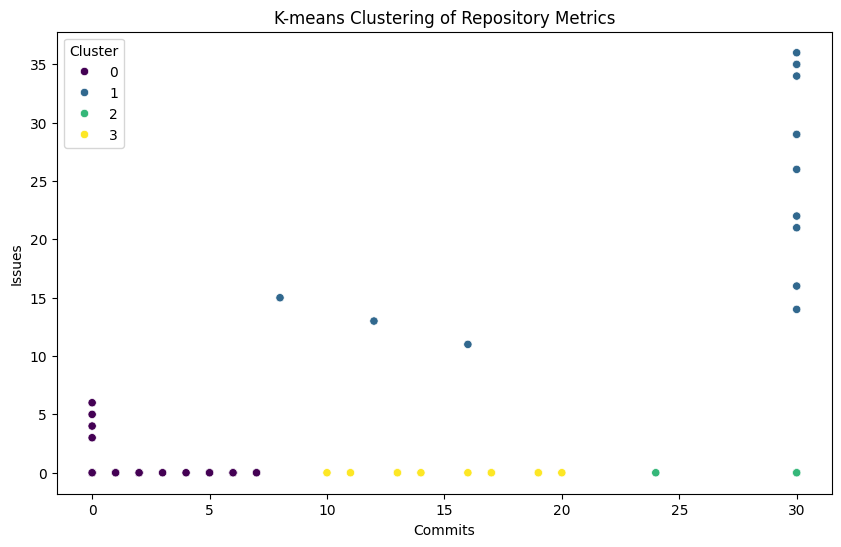

Data with cluster labels saved to repository_metrics_with_clusters.csv


In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv("repository_metrics.csv")

# Preprocess the data
# Drop the 'id', 'name', 'url', and 'month' columns as they are not needed for clustering

#name,Github_link,month,commits,issues,pulls

data = df.drop(columns=['name', 'Github_link', 'month'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can change the number of clusters
kmeans.fit(scaled_data)

# Add the cluster labels to the original DataFrame
df['cluster'] = kmeans.labels_

# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='commits', y='issues', hue='cluster', data=df, palette='viridis')
plt.title('K-means Clustering of Repository Metrics')
plt.xlabel('Commits')
plt.ylabel('Issues')
plt.legend(title='Cluster')
plt.show()

# Save the DataFrame with cluster labels to a new CSV file
df.to_csv("repository_metrics_with_clusters.csv", index=False)
print("Data with cluster labels saved to repository_metrics_with_clusters.csv")